## A3 - K-Means & K-Medioids Clustering

The previous assignments have been about **supervised learning**. In this assignment we move into the **unsupervised** part of the field. Imagine that you get a dataset, without labels. You don't really know the classes of the objects in there, but you want to get an understanding of the structure of the dataset. It would be nice if you could discover which items in the dataset are similar enough that they might belong to the same class. We do this by using **clustering** algorithms, like $k-$means and $k-$medoids. 

The $k$ here stands for the number of clusters you expect to find. But how do you know how many clusters you're looking for? Sometimes you already have some external knowledge, or you just have capacity to handle a certain number of different classes so you just want the best clustering for the $k$ that you have. But there are also methods for getting an idea which value of $k$ best fits the data.

**Take a look at the How do we grade section! We have noticed that students are missing "easy" points due to for example handing in incomplete graphs. (The exact requirements for a graph can be found in the How do we grade section)**

## Organizational

### What you will learn

* Visualizing clusters
* Using the $k-$means and $k-$medoids algorithms
* Measuring the quality of clusters, with and without ground truth
* How to choose $k$?
* Generating adversarial data

### What to submit

* This assignment doesn't use unit tests, because it's largely about visualization, interpretation, and machine learning on data without known ground truth. However, we do want you to submit some code that we can run. This should go into **A3.py**. You should **not** use any packages that aren't already included in the code skeleton. **We should be able to just download your file and run it.**

* In exercise 5 you are asked to generate a dataset and submit it as a csv file. Name it **A3.csv** and submit it through **Github** along with your code.

* Make a PDF report with your plots, tables and written analysis. You can use `A3_STUDENTNUMBER.tex` as a template to make it in Overleaf if you wish. It should be named `A3_s1234567890.pdf`, but using your own student number instead of 1234567890. Hand the PDF report in through **Brightspace**.

    Since this assignment involves a lot of visualization, there is no page limit. However, you should keep your text answer concise and to the point --- there is no need to write a novel.

* **If you do not submit both `A3.py` and `A3.csv` to Github and the PDF report to Brightspace, you will fail this assignment.**

* **This is an individual assignment. Your code and report must be your own work.**

### How we grade

Each exercise is worth 20% of the grade. We look in particular at:
* Whether you did all the things asked for in the exercise. (We can't give you points for things you didn't do.)
* Your analysis of figures and experiments in the report.
* Staying concise in your writing! Academic journals often give you strict page limits.
* Whether your code works. We should be able to run your code without extra configuration or bug-fixing.
* **Good plots. A good plot always has: a title, a caption describing what it shows, axis labels. Usually it also has a scale and if appropriate, units. A legend may be appropriate. Text should be readable. These requirements apply to all following assignments as well. **
* If you get inspiration or information from blogs, papers etc. -- that's okay, as long as you implement it yourself and understand it well enough to report on it. Also, make sure to cite your sources.


## Preliminaries

In [2]:
# The standard scikit-learn package doesn't inclide KMedoids, so we have to install this package
!pip install scikit-learn-extra

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # used to get nice integer axis labels, see https://stackoverflow.com/a/34880501/12734641
import matplotlib.cm as cm

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, completeness_score, homogeneity_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

## Visualizing clusters

Let's start by getting some data to work with

In [3]:
url = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/vehicles.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0)

X = df.iloc[:, :-1]  # all except the last column
y = df.iloc[:, -1]  # the last column

df

,weight,speed,label
0,2201.06,115.39,1
1,2211.89,105.17,1
2,2203.92,89.26,1
3,2344.21,109.98,1
4,2207.76,123.17,1
...,...,...,...
245,68.12,6.03,5
246,75.92,6.15,5
247,84.85,7.78,5
248,101.17,4.06,5


As you can see, this data is labeled -- we have ground truth for the data. That's an assumption we will drop later in this assignment. Now let's visualize it.

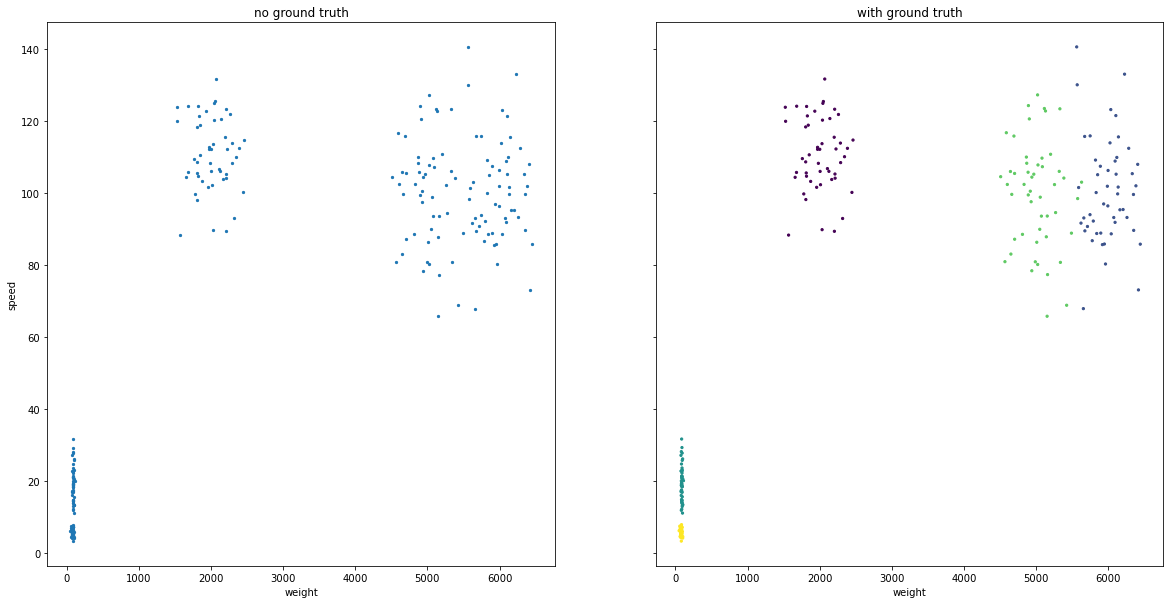

In [4]:
x = df['weight']
y = df['speed']
c = df['label']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax1.scatter(x=x, y=y, s=5)
ax1.set_title('no ground truth')
ax1.set_xlabel('weight')
ax1.set_ylabel('speed')
ax2.scatter(x=x, y=y, c=c, s=5)
ax2.set_title('with ground truth')
ax2.set_xlabel('weight')
plt.show()

The above plot shows the same data, visualized with and without ground truth.  If you look at the code, it might look a bit unfamiliar compared to earlier matplotlib code we've used. The word that sticks out is probably `ax`. A matplotlib object with the `Axes` class is what you think of as a plot - defined by an X-axis and an Y-axis. The "Figure" is also the stuff around it, basically the canvas on which the Axes objects are drawn. What you see here is one Figure that contains two Axes objects and the Axes objects each have an X-axis and an Y-axis. Using this more elaborate way of writing enables us to place them side by side like this. 

To make this a bit simpler, consider the picture taken from [this excellent matplotlib tutorial](https://realpython.com/python-matplotlib-guide/):

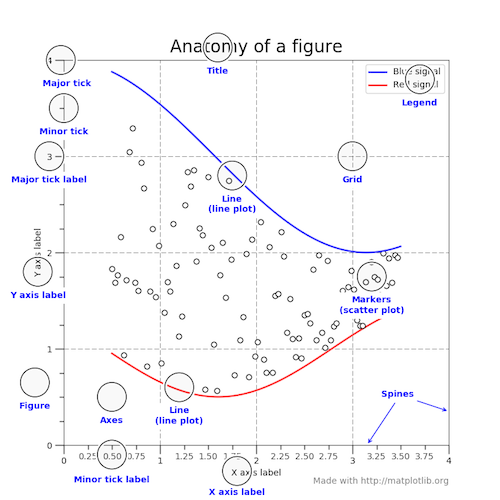



The key thing to pay attention to here is that we can do most of the operations that we're using to doing with `plt` on `ax1` and `ax2` instead, so that we can plot different things in each of them. There are some differences in how the methods are written though, like how `plt.title(...)` becomes `ax1.set_title(...)`, so be careful with that.

### Scikit-Learn style clustering

Scikit-Learn provides us with a KMeans implementation; documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). There is also a KMedoids implementation in [Scikit-Learn Extra](https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html). The usage is fairly straightforward:

In [7]:
k=5  # try for yourself with different values

modelmeans = KMeans(n_clusters=k)
model.fit(X)
print('centroids:\n', model.cluster_centers_, '\n')
print('labels:\n', model.labels_)

centroids:
 [[2226.09  112.13]
 [2006.01  105.9 ]
 [1806.19  108.54]
 [  84.83   14.74]
 [5575.92   98.35]] 

labels:
 [0 0 0 0 0 1 0 2 1 2 1 2 0 1 2 1 2 1 0 0 2 1 2 1 2 1 1 1 1 0 0 2 2 1 2 2 0
 1 2 0 2 2 0 0 0 2 2 2 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [6]:
k=5  # try for yourself with different values

model = KMedoids(n_clusters=k)
model.fit(X)
modelmedoids = model
print('centroids:\n', model.cluster_centers_, '\n')
print('labels:\n', model.labels_)

centroids:
 [[2226.09  112.13]
 [2006.01  105.9 ]
 [1806.19  108.54]
 [  84.83   14.74]
 [5575.92   98.35]] 

labels:
 [0 0 0 0 0 1 0 2 1 2 1 2 0 1 2 1 2 1 0 0 2 1 2 1 2 1 1 1 1 0 0 2 2 1 2 2 0
 1 2 0 2 2 0 0 0 2 2 2 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


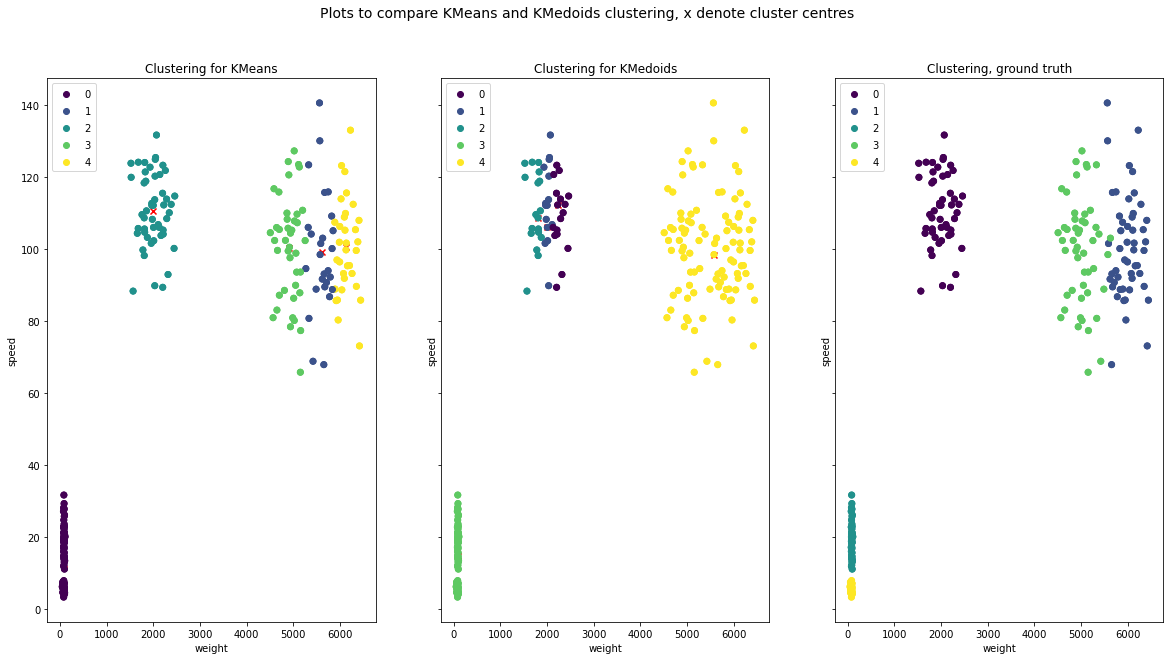

In [627]:
x = df['weight']
y = df['speed']
c = modelmeans.labels_
d = modelmedoids.labels_
e = df['label'] -1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10), sharex=True, sharey=True)
ax1.scatter(x, y, c=c)
ax1.scatter(modelmeans.cluster_centers_[:, 0], modelmeans.cluster_centers_[:, 1], marker='x', color='red')
ax2.scatter(x, y, c=d)
ax2.scatter(modelmedoids.cluster_centers_[:, 0], modelmedoids.cluster_centers_[:, 1], marker='x', color='red')
ax3.scatter(x, y, c=e)

ax1.set_title('Clustering for KMeans')
ax1.set_xlabel('weight')
ax1.set_ylabel('speed')
ax1.legend(*ax1.scatter(x=x,y=y,c=c).legend_elements())

ax2.set_title('Clustering for KMedoids')
ax2.set_xlabel('weight')
ax2.set_ylabel('speed')
ax2.legend(*ax2.scatter(x=x,y=y,c=d).legend_elements())

ax3.set_title('Clustering, ground truth')
ax3.set_xlabel('weight')
ax3.set_ylabel('speed')
ax3.legend(*ax3.scatter(x=x,y=y,c=e).legend_elements())

plt.suptitle(f"Plots to compare KMeans and KMedoids clustering, x denote cluster centres",
            fontsize=14)
plt.show()

#### Task 1: visualizing clustering results


* Apply `KMeans` and `KMedoids` with $k=5$ (because we know from the ground truth that there are 5 labels).
* Make three plots side by side, two showing the clusters that your models learned, and the last one showing the ground truth.
* Of course each plot should have a title, axis labels and legend.
* For the `KMeans` and `KMedoids` learned clusters plot, also plot the **centroids**. Use a differently shaped marker (for example an x) to make them distinguishable.
* Put this side-by-side plot in your report and give a brief analysis of how well the models appear to be doing.

## Evaluating clusters with ground truth

If we know the ground truth of a dataset that we're clustering on, we can use many of the methods we've used in the previous assignments. This does require a couple of workarounds though --- the clustering algorithm assigns items to clusters $1\ldots k$, but there's no guarantee those happen to be in the same order as our classes $1\ldots k$. For example, cluster 2 might correspond to label 3.

However, we have some useful alternatives at our disposal in scikit-learn:

* [Homogeneity score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html) measures if all instances assigned to a cluster have the same class.

* [Completeness score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html) measures whether clusters contain all of the instances of one class.

These measures resemble the measures we've used before, like precision and recall, but are also a bit different because they work with an uncertain number of clusters, as well as possible permutations between cluster labels and true class labels.

#### Task 2: $k-$means vs. $k-$medoids


You can use https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/dataset-task-2.csv, or generate your own datasets using for example [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

The task is to compare `KMeans` and `KMedoids` on a dataset using homogeneity and completeness scores. Write code to do the following:

* Train the models.
* Make scatterplots of their performance. Also scatterplot the true labels for visual comparison.

And report the following:
* Your plots.
* If you made a dataset of your own, how you made it and why you did it that way.
* Which value of $k$ you used for each model.
* Which model performed better? Do you have any idea why?
* Describe for both models a situation where it would be a better choice than the other.

Values are left to right homogeinity respectively completeness scores,
top to bottom KMeans respectively KMedoids.
0.41691717026095754 0.41944139604605907
0.37283026051876395 0.3782070459442628


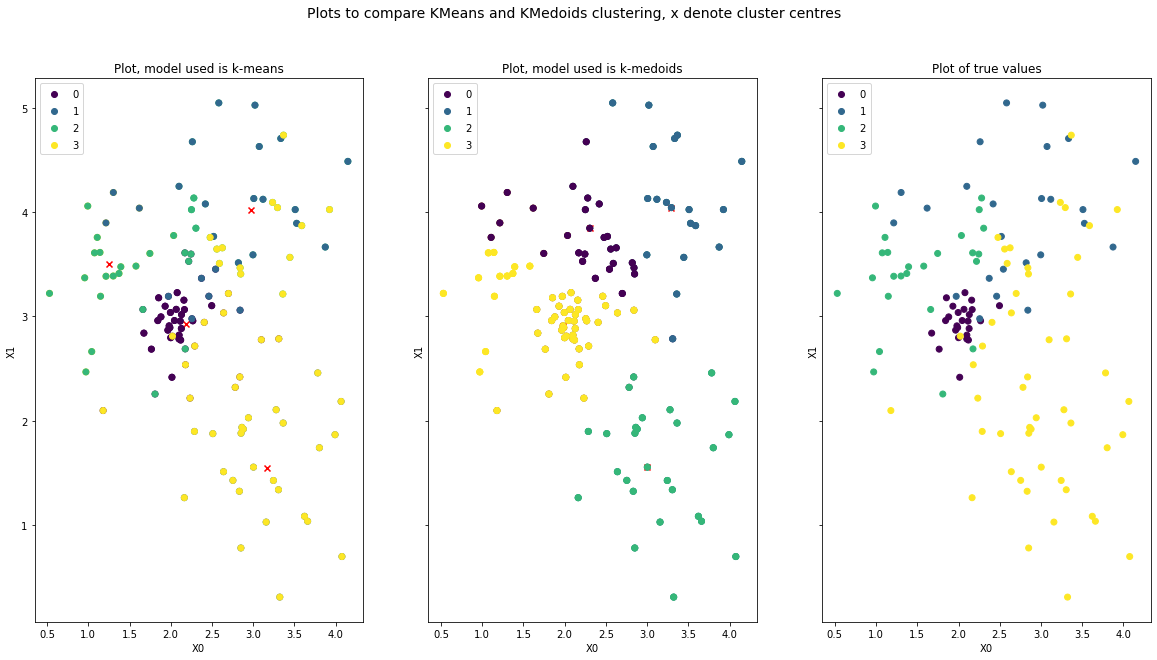

In [630]:
url = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/dataset-task-2.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0)

X = df.iloc[:, :-1].values  # all except the last column
y = df.iloc[:, -1].values  # the last column

k = 4


#training models 


modelmeans = KMeans(n_clusters=k)
modelmedoids = KMedoids(n_clusters=k)
modelmeans.fit(X)
modelmedoids.fit(X)
#print(y)
#print('centroids:\n', modelmeans.cluster_centers_, '\n')
#print('labels:\n', modelmeans.labels_)
#print('centroids:\n', modelmedoids.cluster_centers_, '\n')
#print('labels:\n', modelmedoids.labels_)

#plotting models 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10), sharex=True, sharey=True)

ax1.scatter(X[:, 0], X[:, 1], c=modelmeans.labels_)
ax1.scatter(modelmeans.cluster_centers_[:, 0], modelmeans.cluster_centers_[:, 1], marker='x', color='red')
ax1.set_title("Plot, model used is k-means")
ax1.set_xlabel("X0")
ax1.set_ylabel("X1")
ax1.legend(*ax2.scatter(x=X[:, 0],y=X[:, 1],c=modelmeans.labels_).legend_elements(), loc="upper left")

ax2.scatter(X[:, 0], X[:, 1], c=modelmedoids.labels_)
ax2.set_title("Plot, model used is k-medoids")
ax2.scatter(modelmedoids.cluster_centers_[:, 0], modelmedoids.cluster_centers_[:, 1], marker='x', color='red')
ax2.set_xlabel("X0")
ax2.set_ylabel("X1")
ax2.legend(*ax2.scatter(x=X[:, 0],y=X[:, 1],c=modelmedoids.labels_).legend_elements(), loc="upper left")

ax3.scatter(X[:, 0], X[:, 1], c=y, label=y)
ax3.set_title("Plot of true values")
ax3.set_xlabel("X0")
ax3.set_ylabel("X1")
ax3.legend(*ax1.scatter(x=X[:, 0],y=X[:, 1],c=y).legend_elements(), loc="upper left")

plt.suptitle(f"Plots to compare KMeans and KMedoids clustering, x denote cluster centres",
            fontsize=14)

plt.plot()

#get homogenity and completeness scores

mean_homogeneity = homogeneity_score(y, modelmeans.labels_)
medoids_homogeneity = homogeneity_score(y, modelmedoids.labels_)
mean_completeness = completeness_score(y, modelmeans.labels_)
medoids_completeness = completeness_score(y, modelmedoids.labels_)

print("Values are left to right homogeinity respectively completeness scores,")
print("top to bottom KMeans respectively KMedoids.")
print(mean_homogeneity, mean_completeness)
print(medoids_homogeneity, medoids_completeness)

## Evaluating clusterings without known ground truth

As a data scientist you will often run into data where the ground truth is not known. You can still use clustering, unlike some other techniques, because it's an unsupervised technique. You could even use that as the start of a longer investigation: first you use clustering to get an idea of what sort of groups exist in the data, then you study the clusters to try to identify classes.

When using $k-$means and $k-$medoids, you'll need to decide what value of $k$ to use however, and this can be tricky. The obvious thing is to use a measure for cluster quality that doesn't require knowing the ground truth. If we have such a measure, then we can just try our algorithms for various values of $k$ and see which one gives the best results. That's what we'll be doing in the next section, using two different measures: **silhouette** and **inertia**.

### The Silhouette Method

We will use a code fragment from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). To make this more advanced plotting code a bit easier to follow we've restructured it a bit and we'll go through it step by step. We start out by making some data with a convenient scikit-learn function:

In [10]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility


Here we see `make_blobs` used to generate 4 clusters. There's no real ground truth, just distributions centered around randomly chosen points. What does it look like?

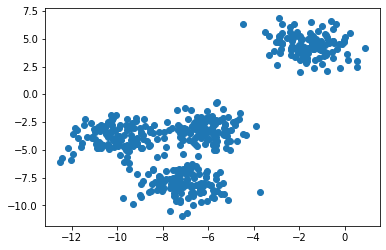

In [11]:
plt.scatter(X[:,0], X[:,1])
plt.show()

Okay, with the naked eye we can see exactly what the documentation predicted, one distinct cluster and three clusters placed close to each other.

Now, we're going to run the actual experiment. We are trying out $k$ for all the values listed in `range_n_clusters`, and for each of them we do the following:
1. Run the clustering
1. Initialize a two-plot figure
1. Make the left plot
1. Make the right plot

And when it's done, we show all the plots for comparison.

For n_clusters = 2, the average silhouette_score is :0.7049787496083262
For n_clusters = 3, the average silhouette_score is :0.5882004012129721
For n_clusters = 4, the average silhouette_score is :0.6505186632729437
For n_clusters = 5, the average silhouette_score is :0.56376469026194
For n_clusters = 6, the average silhouette_score is :0.4504666294372765


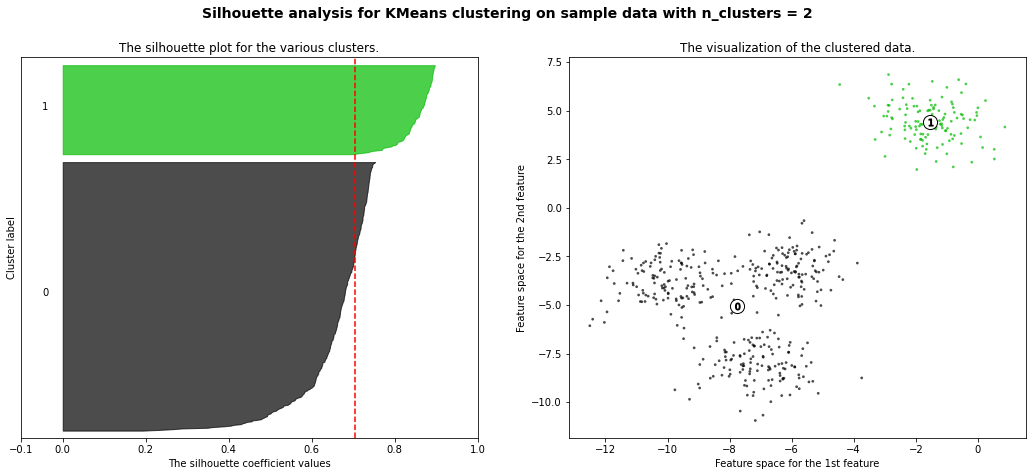

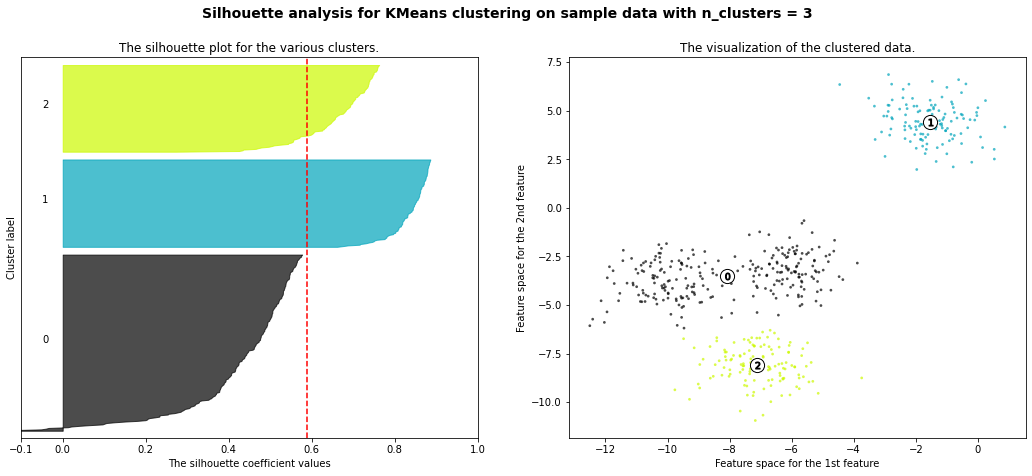

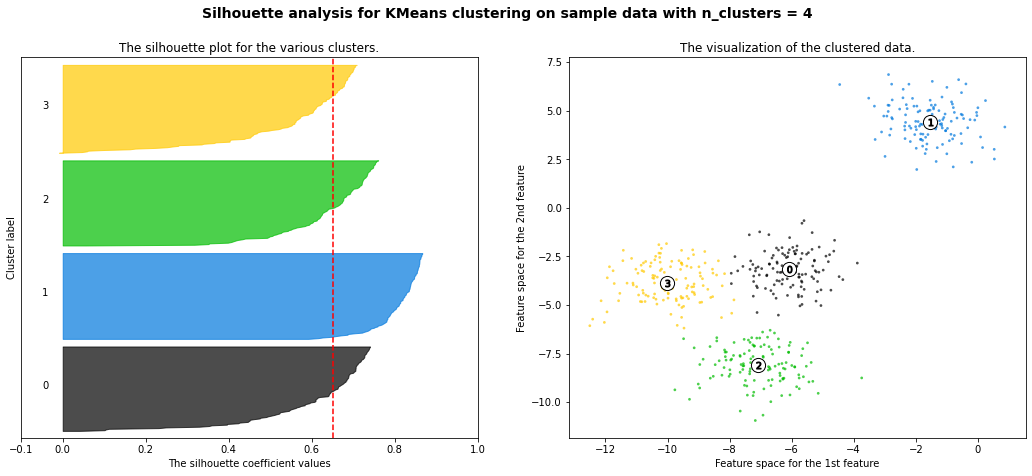

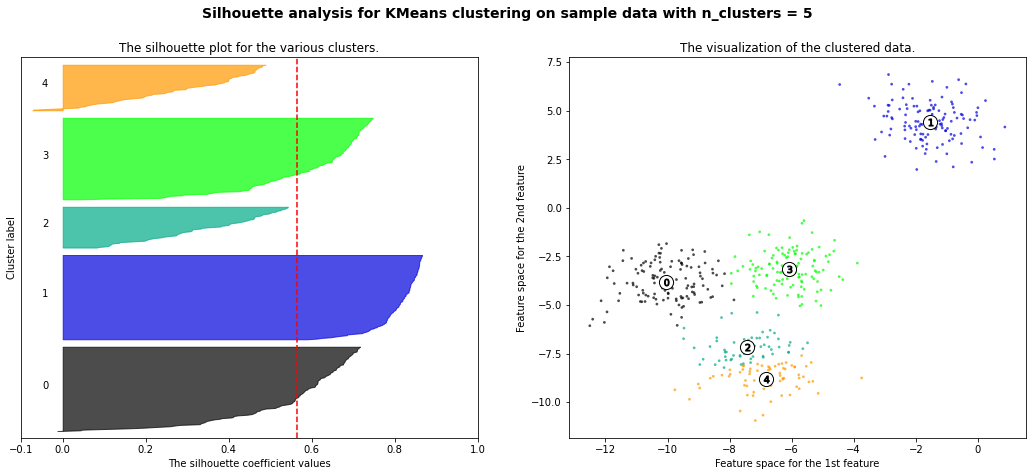

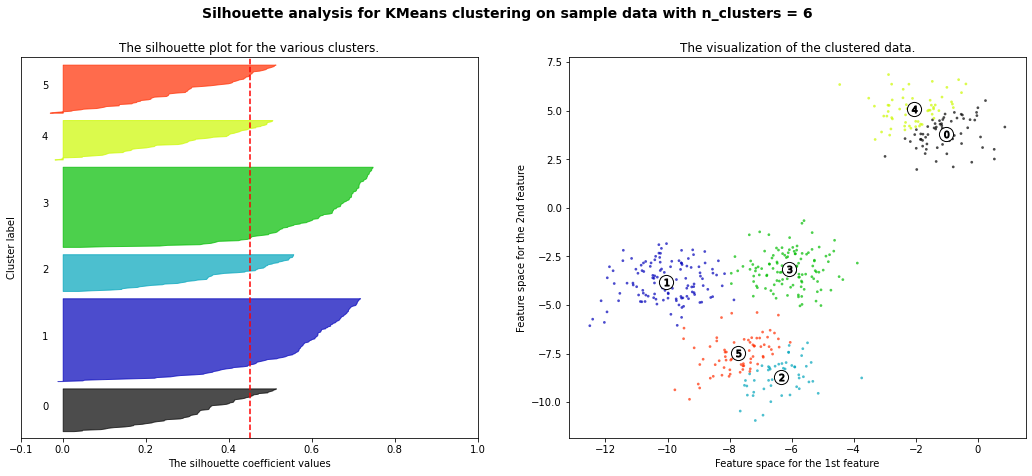

In [12]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:

    ### FIRST, DO THE ACTUAL CLUSTERING ###

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is :{silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)


    ### SET UP THE TWO-PLOT FIGURE ###

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)


    ### LEFT PLOT ###

    # The 1st subplot is the silhouette plot
    ax1.set_title("The silhouette plot for the various clusters.")

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_xlim([-0.1, 1])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylabel("Cluster label")
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks

    

    y_lower = 10  # starting position on the y-axis of the next cluster to be rendered

    for i in range(n_clusters): # Here we make the colored shape for each cluster

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        # Figure out how much room on the y-axis to reserve for this cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        y_range = np.arange(y_lower, y_upper)

        # Use matplotlib color maps to make each cluster a different color, based on the total number of clusters.
        # We use this to make sure the colors in the right plot will match those on the left.
        color = cm.nipy_spectral(float(i) / n_clusters)

        # Draw the cluster's overall silhouette by drawing one horizontal stripe for each datapoint in it
        ax1.fill_betweenx(y=y_range,                            # y-coordinates of the stripes
                          x1=0,                                 # all stripes start touching the y-axis
                          x2=ith_cluster_silhouette_values,     # ... and they run as far as the silhouette values
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")



    ### RIGHT PLOT ###

    # 2nd Plot showing the actual clusters formed
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
                 fontsize=14, fontweight='bold')

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)  # make the colors match with the other plot
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    # Put numbers in those circles
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')




### FINISH ###
plt.show()  # show all the plots, in the order they were generated


#### Task 3: using silhouette to compare $k-$means and $k-$medoids.

In this exercise you have to adapt the code fragment above to do a comparison of $k-$means and $k-$medoids.

* Load the data from https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/dataset-task-3.csv
* Make a clustering using `KMeans` and another one using `KMedoids`, using $k=4$.
* Adapt the code sample to compare the clusterings generated by both models.

What to submit:
* A silhouette + clustering figure for both `KMeans` and `KMedoids`.
* Report the scores both models get.
* Analyze which one seems to be working better. Why do you think it works better?

For n_clusters = 4, the average silhouette_score is :0.43236875834296057


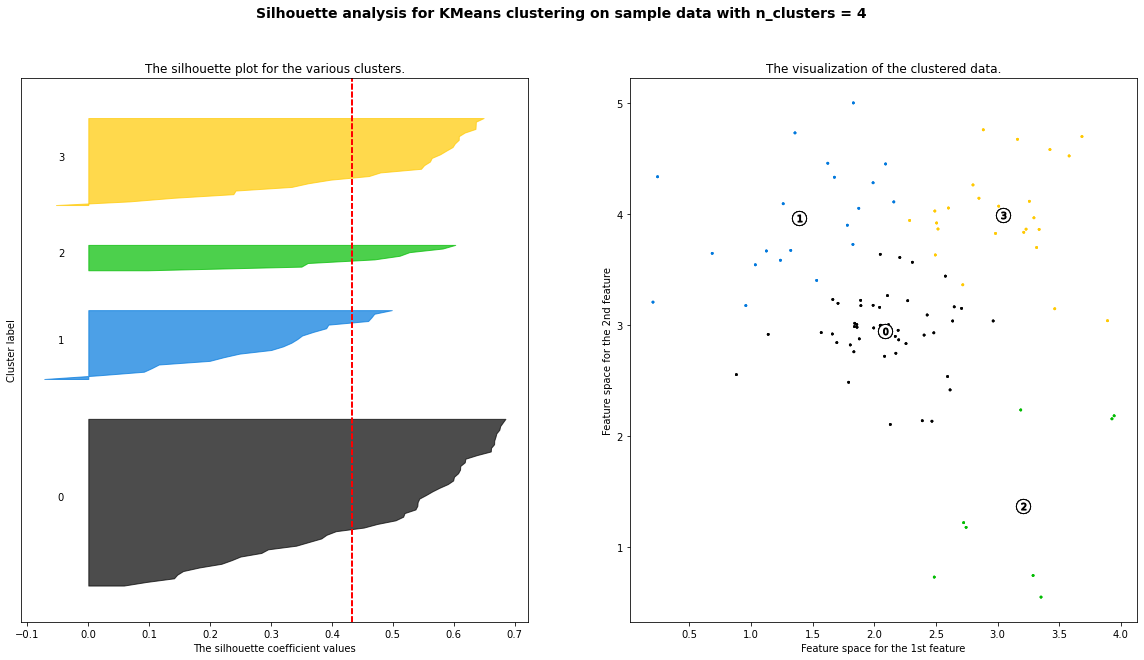

For n_clusters = 4, the average silhouette_score is :0.28277766682776956


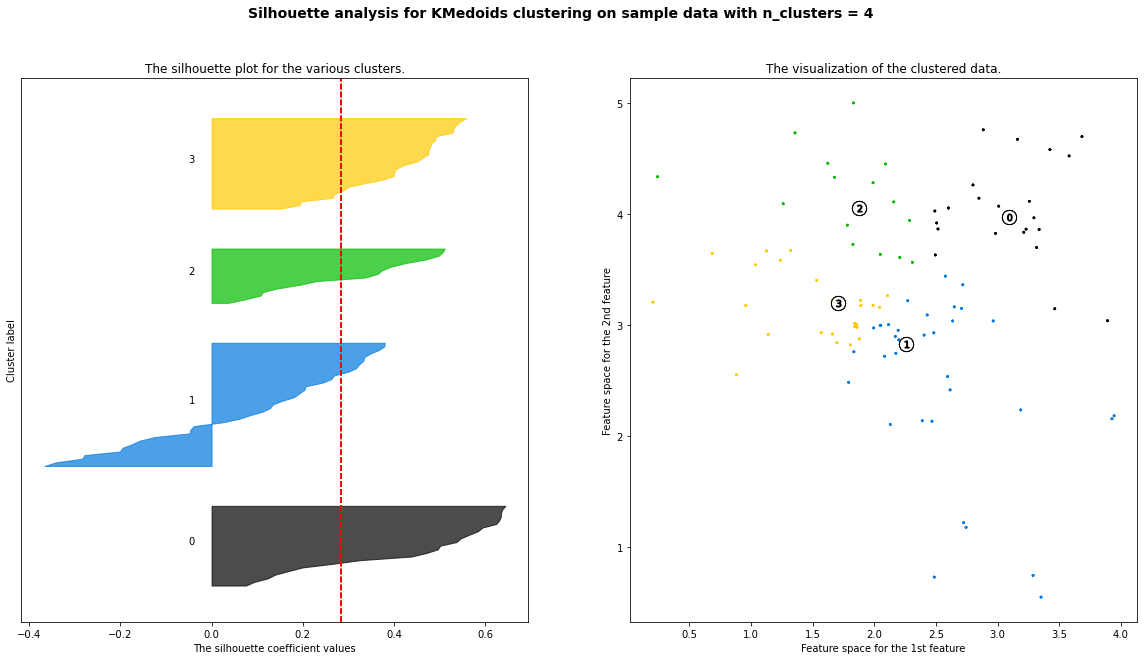

In [8]:
url = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/dataset-task-3.csv'
df = pd.read_csv(filepath_or_buffer=url, header=0)

X = df.iloc[:, :].values  # all except the last column

k = 4
n_clusters = k

#Train models 

modelmeans = KMeans(n_clusters=k, random_state=None)
modelmeans_labels = modelmeans.fit_predict(X)
modelmeans_centers = modelmeans.cluster_centers_
modelmedoids = KMedoids(n_clusters=k, random_state=None)
modelmedoids_labels = modelmedoids.fit_predict(X)
modelmedoids_centers = modelmedoids.cluster_centers_



# Compute the silhouette scores for each sample


def model_comparison_plot(k, X, model_name, labels, centers):
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, labels)
    print(f"For n_clusters = {k}, the average silhouette_score is :{silhouette_avg}")
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    y_lower = 10  # starting position on the y-axis of the next cluster to be rendered
    sample_silhouette_values = silhouette_samples(X, labels)
    for i in range(k): # Here we make the colored shape for each cluster

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        # Figure out how much room on the y-axis to reserve for this cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        y_range = np.arange(y_lower, y_upper)
    
        # Use matplotlib color maps to make each cluster a different color, based on the total number of clusters.
        # We use this to make sure the colors in the right plot will match those on the left.
        color = cm.nipy_spectral(float(i) / k)

        # Draw the cluster's overall silhouette by drawing one horizontal stripe for each datapoint in it
        ax1.fill_betweenx(y=y_range,                            # y-coordinates of the stripes
                          x1=0,                                 # all stripes start touching the y-axis
                          x2=ith_cluster_silhouette_values,     # ... and they run as far as the silhouette values
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    
        # The 1st subplot is the silhouette plot
        ax1.set_title("The silhouette plot for the various clusters.")

        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlabel("The silhouette coefficient values")

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylabel("Cluster label")
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ### RIGHT PLOT ###

        # 2nd Plot showing the actual clusters formed
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(f"Silhouette analysis for {model_name} clustering on sample data with n_clusters = {n_clusters}",
                 fontsize=14, fontweight='bold')

        colors = cm.nipy_spectral(labels.astype(float) / k)  # make the colors match with the other plot
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

        # Labeling the clusters
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
        # Put numbers in those circles
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    plt.show()

model_comparison_plot(k, X, "KMeans", modelmeans_labels, modelmeans_centers)
model_comparison_plot(k, X, "KMedoids", modelmedoids_labels, modelmedoids_centers)

### The Elbow Method

Suppose you had a measure of how poorly a clustering is doing, like **inertia**. Inertia measures the distance of data points in a cluster to the centroid of that cluster. Obviously if we set $k$ to the same number of the number of data points, then we would get zero inertia, because each data point is exactly on the centroid of its one-point cluster. But this model would be very uninformative. So we can't just minimize inertia and pick that value as $k$. But as it turns out, there's a very straightforward heuristic method. For $k = 1\ldots n$ you run the clustering algorithm, and record the inertia value of the model. Then you make a plot of $k$ vs inertia, like this:


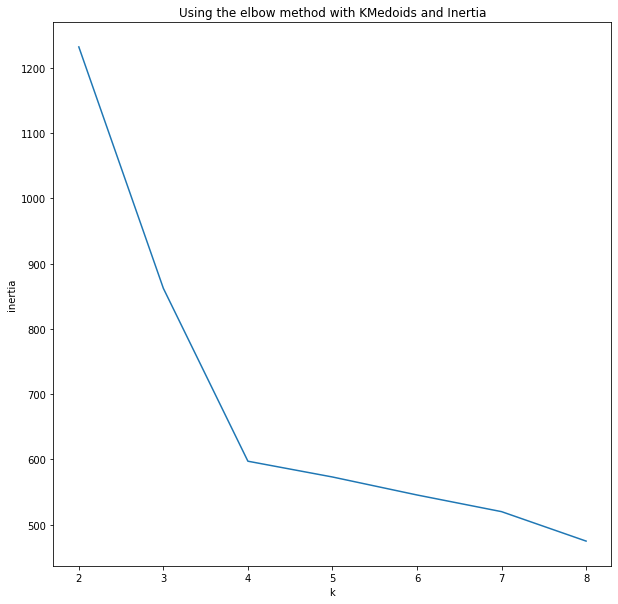

We can see an "elbow" like shape in this plot, and the joint of the elbow is clearly at $k = 4$, so the heuristic says that this data seems to have 4 real clusters in them. After that the inertia still goes down, but not so very fast. But keep in mind that the elbow method is a *heuristic*; it's not guaranteed to always be correct, but it works in most of the cases. And if you're dealing with data for which you don't have any ground truth and no idea what $k$ might be, it's definitely useful.

You can see that even after $k=4$ the inertia continues to decrease. For an idea why, let's look at the formula for inertia:

$$\sum_{i=1}^k \sum_{j=1}^{|C_i|} d(c_i, p_{i, j})^2$$

Let's unpack that formula a bit. 
* The left summation shows that we're summing up over $i \in 1\ldots k$, so this is a sum of *something* over all the $k$ clusters. 
* Then the right summation has $j$ going from 1 to the cardinality (= the number of items in the set) $C_i$, the $i-$th cluster. 
* Then we have $d(a, b)^2$ as the squared distance between two points. This could be Euclidean distance or some other kind of distance measure that we're using.
* $c_i$ is the centroid of cluster $C_i$.
* $p_{i, j}$ is the $j-$th point assigned to cluster $C_i$.

So putting that all back together, what we have is the sum of all squared distances of points to their cluster centroids.

Conveniently, you don't have to calculate that yourself, it's already implemented in scikit-learn. If you have fitted a `KMeans` or `KMedoids` model you can just look up this value:

```python
print(model.inertia_)
```

#### Task 4: use the elbow method to find $k$

Use the elbow method to discover the most likely value of $k$ used to generate datasets 4a and 4b. You can use KMeans, KMedoids, or both if you like.

What to submit:
* Figures of the elbow plots you generated.
* A table with the $k$-values you think were used to generate each dataset.
* Explanation why you chose those values.

Notice that these datasets are not 2D anymore, so visualizing them and judging by directly looking at the data isn't always practical. That's why the elbow method can be a useful heuristic.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "


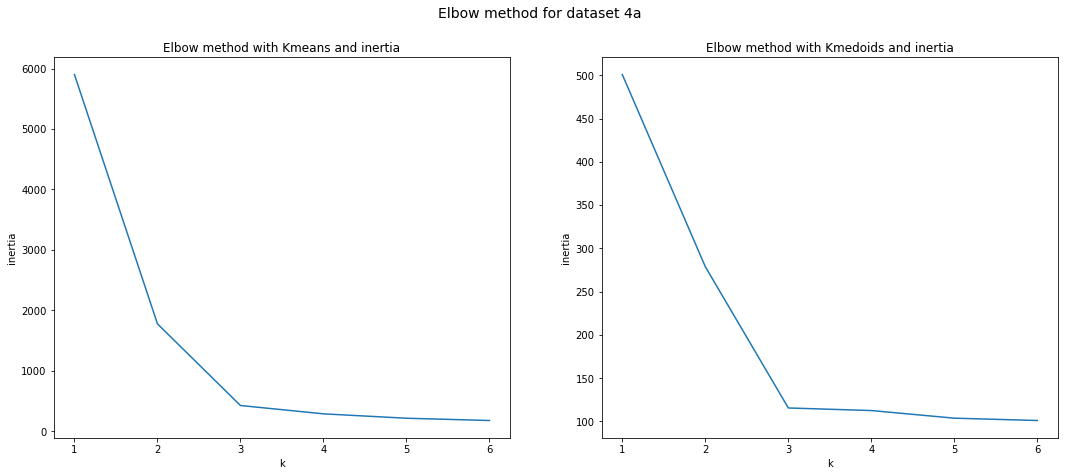

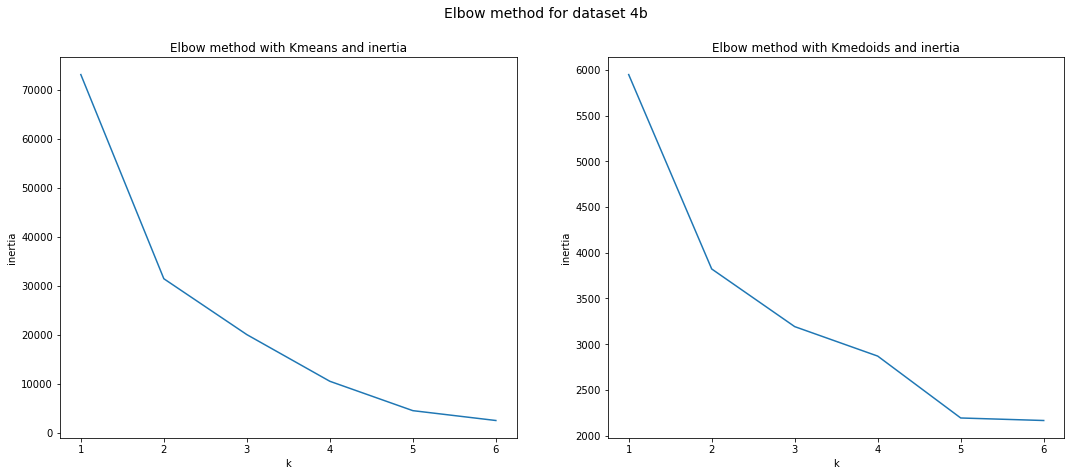

In [76]:
#Importing both datasets 
k_max = 6
url1 = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/dataset-task-4a.csv'
url2 = 'https://raw.githubusercontent.com/MLCourse-LU/Datasets/main/dataset-task-4b.csv'

df1 = pd.read_csv(filepath_or_buffer=url1, header=0)
df2 = pd.read_csv(filepath_or_buffer=url2, header=0)


X = df1
Y = df2 

k_values = np.arange(1, k_max+1)
#Calculate values of inertia 
inertia = np.zeros([4, k_max])
for k in range(1, k_max+1):
    modelmeans = KMeans(n_clusters=k) #fitting model
    modelmedoids = KMedoids(n_clusters=k)
    modelmeans.fit(X)
    modelmedoids.fit(X)
    inertia[0, k-1], inertia[1, k-1] = modelmeans.inertia_, modelmedoids.inertia_
    
    modelmeans2 = KMeans(n_clusters=k)
    modelmedoids2 = KMedoids(n_clusters=k)
    modelmeans2.fit(Y)
    modelmedoids2.fit(Y)
    inertia[2, k-1], inertia[3, k-1] = modelmeans2.inertia_, modelmedoids2.inertia_
    
#Plot inertia
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.plot(k_values, inertia[0, :])
ax1.set_title("Elbow method with Kmeans and inertia")
ax1.set_xlabel("k")
ax1.set_ylabel("inertia")

ax2.plot(k_values, inertia[1, :])
ax2.set_title("Elbow method with Kmedoids and inertia")
ax2.set_xlabel("k")
ax2.set_ylabel("inertia")

plt.suptitle(f"Elbow method for dataset 4a", fontsize=14)
plt.show()

#Plot inertia
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.plot(k_values, inertia[2, :])
ax1.set_title("Elbow method with Kmeans and inertia")
ax1.set_xlabel("k")
ax1.set_ylabel("inertia")

ax2.plot(k_values, inertia[3, :])
ax2.set_title("Elbow method with Kmedoids and inertia")
ax2.set_xlabel("k")
ax2.set_ylabel("inertia")

plt.suptitle(f"Elbow method for dataset 4b", fontsize=14)
plt.show()

## Limitations of $k-$means and $k-$medoids

#### Task 5: difficult clusters
These algorithms are useful and elegantly simple, but they don't always work. In this exercise, we want you to develop a dataset that they have problems with.

Write code that generates a dataset, with the following properties:
* 2 features, so that we can use a simple 2D plot to visualize it.
* Put in $k \geq 3$ different distributions of data into it; you can pick $k$ yourself.
* Easy for a human to cluster just with the naked eye.
* Hard for the `KMedoids` clusterer to properly cluster, even knowing the right value of `k`.

Submit the following:
* The code used. Use only the packages in the code skeleton and it should end with a call to `plt.show()`. We should be able to run your code and see (approximately or exactly) the same results. You can use fixed random seeds if you want.
* Figure(s) in your report showing the ground truth vs. the `KMedoids` clustering.
* A brief explanation of why you used this approach to generate the data.
* A brief analysis of why it's easy for humans to see the correct clusters but hard for $k-$medoids.
* The dataset as a csv file named **A3.csv**.

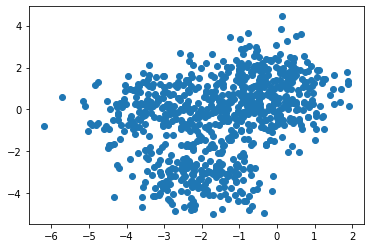

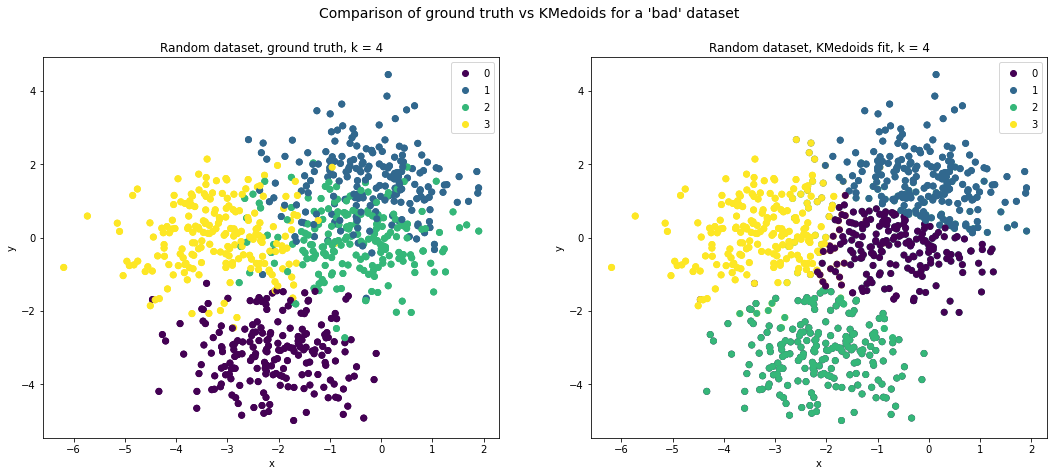

In [616]:
#Generate dataset 

k = 4

X, y = make_blobs(n_samples=800,
                  n_features=2,
                  centers=k,
                  cluster_std=0.9,
                  center_box = (-3.25, 3.25),
                  shuffle=True,
                  random_state=11)  # For reproducibility, random_state = 3000

np.savetxt("A3.csv", X)
modelmedoids = KMedoids(n_clusters = k)
modelmedoids.fit(X)

plt.scatter(X[:, 0], X[:, 1])
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.scatter(X[:, 0], X[:, 1], c=y)
ax1.set_title((f"Random dataset, ground truth, k = {k}"))
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend(*ax1.scatter(x=X[:, 0],y=X[:, 1],c=y).legend_elements(), loc="upper right")

ax2.scatter(X[:, 0], X[:, 1], c=y)
ax2.set_title((f"Random dataset, KMedoids fit, k = {k}"))
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(*ax2.scatter(x=X[:, 0],y=X[:, 1],c=modelmedoids.labels_).legend_elements(), loc="upper right")

              
plt.suptitle(f"Comparison of ground truth vs KMedoids for a 'bad' dataset", fontsize=14)
plt.show()